#### Import Libraries

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from predictor import SimpleSVM

#### Data Import

In [73]:
df = pd.read_csv("Train_data.csv")

#### EDA

In [74]:
df.head()

,Unnamed: 0,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
3,3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0
4,4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0


**Drop irrelevant columns**

In [75]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89564 entries, 0 to 89563
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       89564 non-null  object 
 1   MinTemp        89174 non-null  float64
 2   MaxTemp        89365 non-null  float64
 3   Rainfall       88675 non-null  float64
 4   Evaporation    51319 non-null  float64
 5   Sunshine       47010 non-null  float64
 6   WindGustDir    83700 non-null  object 
 7   WindGustSpeed  83741 non-null  float64
 8   WindDir9am     83256 non-null  object 
 9   WindDir3pm     87182 non-null  object 
 10  WindSpeed9am   88725 non-null  float64
 11  WindSpeed3pm   87911 non-null  float64
 12  Humidity9am    88468 non-null  float64
 13  Humidity3pm    87307 non-null  float64
 14  Pressure9am    80788 non-null  float64
 15  Pressure3pm    80799 non-null  float64
 16  Cloud9am       55708 non-null  float64
 17  Cloud3pm       53535 non-null  float64
 18  Temp9a

In [77]:
df.shape

(89564, 22)

In [78]:
categorical_features = df.select_dtypes(include=["object"]).columns
numerical_features = df.select_dtypes(include=["number"]).columns

print("Number of categorical features:", len(categorical_features))
print("Number of numerical features:", len(numerical_features))

Number of categorical features: 5
Number of numerical features: 17


In [79]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
count,89174.000000,89365.000000,88675.000000,51319.000000,47010.000000,83741.000000,88725.000000,87911.000000,88468.000000,87307.000000,80788.000000,80799.00000,55708.000000,53535.000000,89019.000000,87850.000000,89564.000000
mean,12.171406,23.218279,2.348802,5.456474,7.616856,39.967614,14.000270,18.650590,68.867805,51.428820,1017.683770,1015.28589,4.450007,4.515270,16.970976,21.680404,0.224633
std,6.397401,7.117014,8.548539,4.151161,3.783653,13.592155,8.900799,8.808749,19.083514,20.794155,7.113629,7.04920,2.885373,2.716782,6.495977,6.932432,0.417343
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,978.20000,0.000000,0.000000,-7.000000,-5.100000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.50000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.700000,1015.30000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,65.000000,1022.400000,1020.10000,7.000000,7.000000,21.600000,26.400000,0.000000
max,33.900000,48.100000,371.000000,86.200000,14.300000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1038.20000,9.000000,9.000000,40.200000,46.700000,1.000000


- **Temperature ranges**: `MinTemp` ranges from -8.5 to 33.9, and `MaxTemp` from -4.1 to 48.1, showing a broad range of temperatures.
- **Rainfall**: The mean rainfall is low (2.35 mm), and the 50th percentile (median) is 0, indicating that on most days, there is no rain or very little rain. However, the max rainfall is very high (371.0 mm), suggesting extreme events.
- **WindGustSpeed**: Has a wide range (6.0 to 135.0), with an average of around 40 km/h.
- **Humidity**: `Humidity9am` generally higher (mean ~68.87) than `Humidity3pm` (mean ~51.43), which is expected as humidity tends to drop as the day warms up.
- **Pressure**: `Pressure9am` and `Pressure3pm` are relatively stable with small standard deviations, as expected for atmospheric pressure measurements.
- **Cloudiness**: `Cloud9am` and `Cloud3pm` show significant variability and a large number of missing values.
- RainTomorrow: The mean is 0.2246, indicating that approximately 22.46% of the days had rain the next day, highlighting a class imbalance (more *No Rain* than *Rain*).

**Unique value counts for categorical columns**

In [80]:
for col in df.select_dtypes(include="object").columns:
    print(f"{col}: {df[col].nunique()} unique values -> {df[col].unique()}")

Location: 49 unique values -> ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
WindGustDir: 16 unique values -> ['W' 'WNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'NE' 'WSW' 'NNW' 'S' 'ESE' nan 'NW'
 'E' 'SSW' 'SE']
WindDir9am: 16 unique values -> ['W' 'NNW' 'ENE' 'SSE' 'S' 'NE' nan 'SSW' 'N' 'WSW' 'SE' 'ESE' 'E' 'NW'
 'NNE' 'SW' 'WNW']
WindDir3pm: 16 unique values -> ['WNW' 'WSW' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'SSW' 'E' 'SW' 'NNW' 'N' 'S' nan
 'SE' 'NNE' 'NE']
RainToday: 2 unique

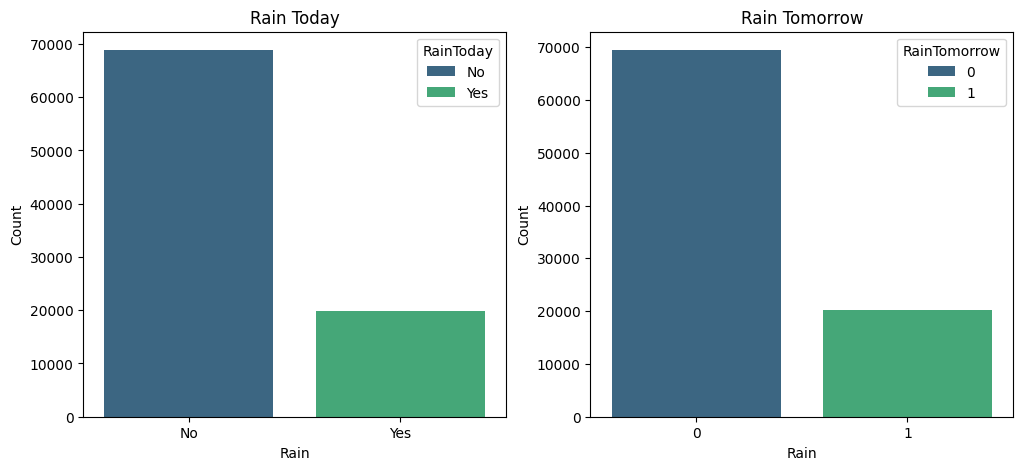

In [81]:
figure, axes = plt.subplots(1,2, figsize=(12,5))

sns.countplot(data=df, x="RainToday", ax=axes[0], palette="viridis", hue="RainToday")
sns.countplot(data=df, x="RainTomorrow", ax=axes[1], palette="viridis", hue="RainTomorrow")

axes[0].set(title = 'Rain Today', xlabel = "Rain", ylabel = "Count")
axes[1].set(title = 'Rain Tomorrow', xlabel = "Rain", ylabel = "Count")

plt.show()

There are significantly more instances of `No Rain` (0) than `Rain` (1). This indicates a class imbalance in the target variable, meaning the dataset contains many more days where it did not rain the next day compared to days where it did. This imbalance is an important observation for model training, as it can affect model performance, and often requires specific handling techniques like *upsampling* or *downsampling* during preprocessing.

**Numerical Features Distribution**

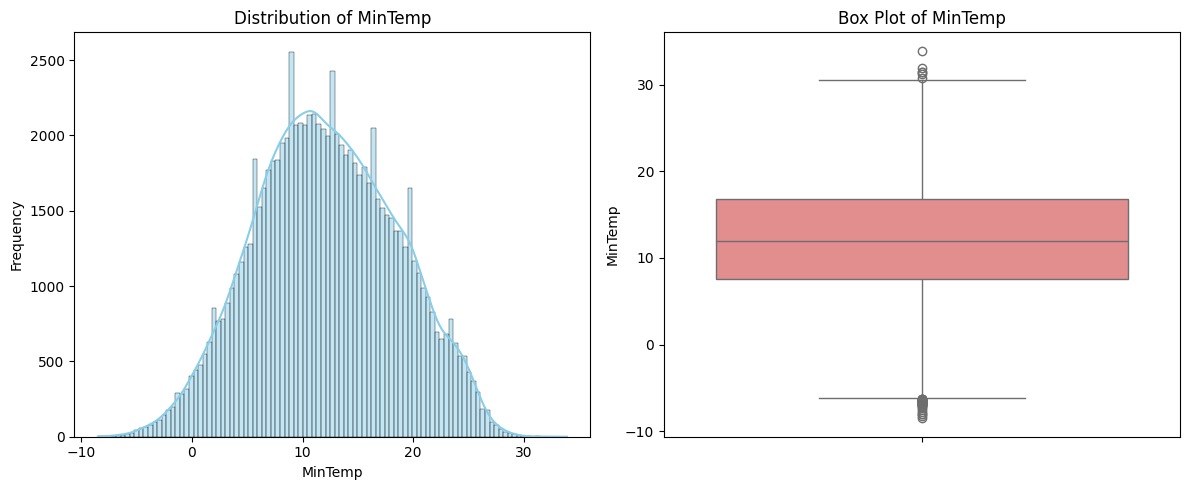

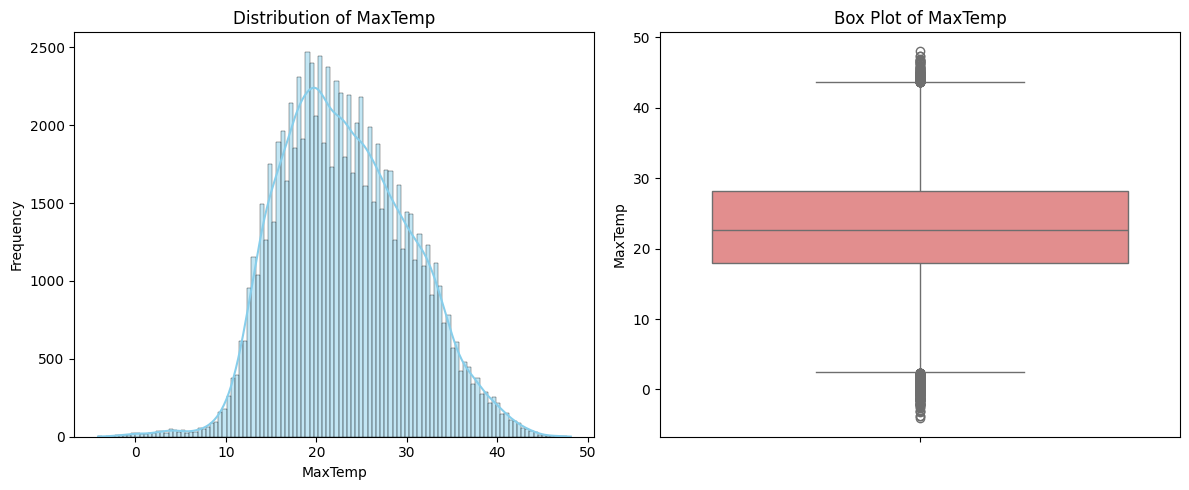

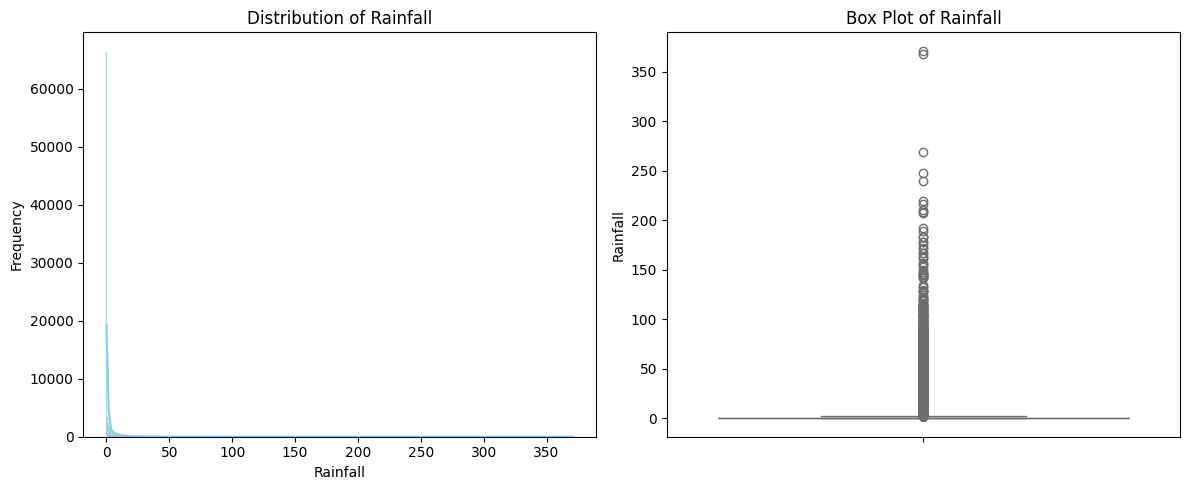

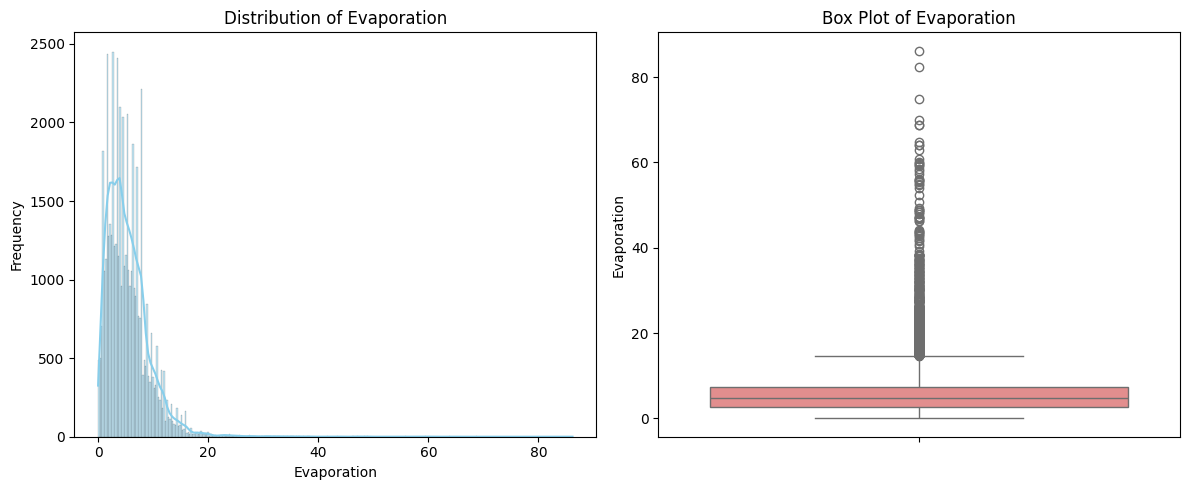

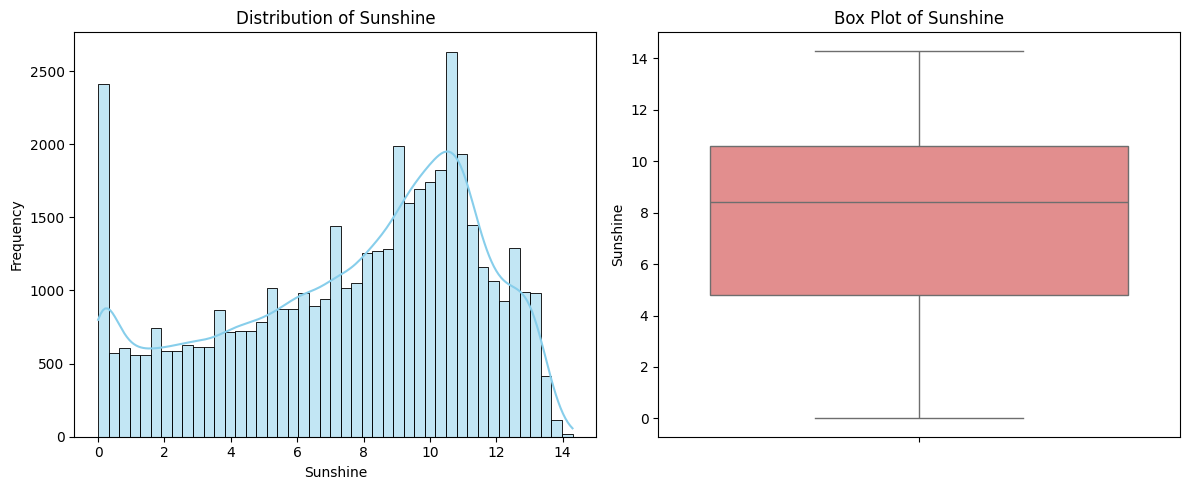

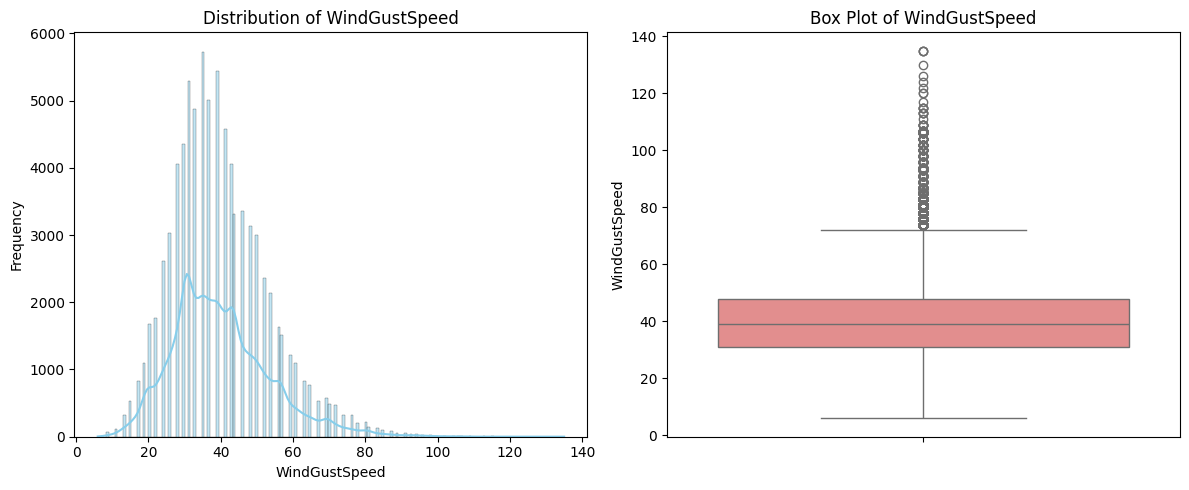

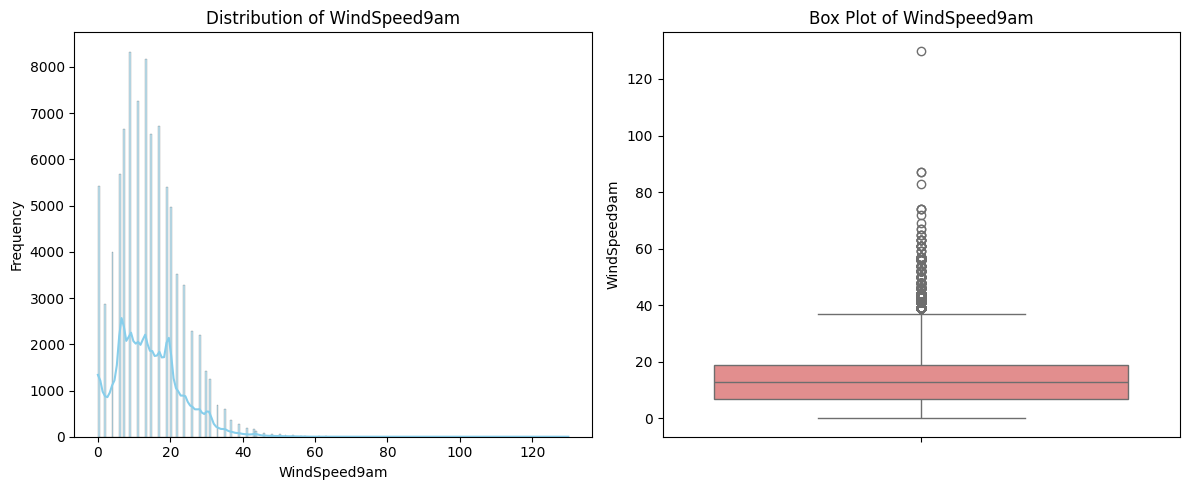

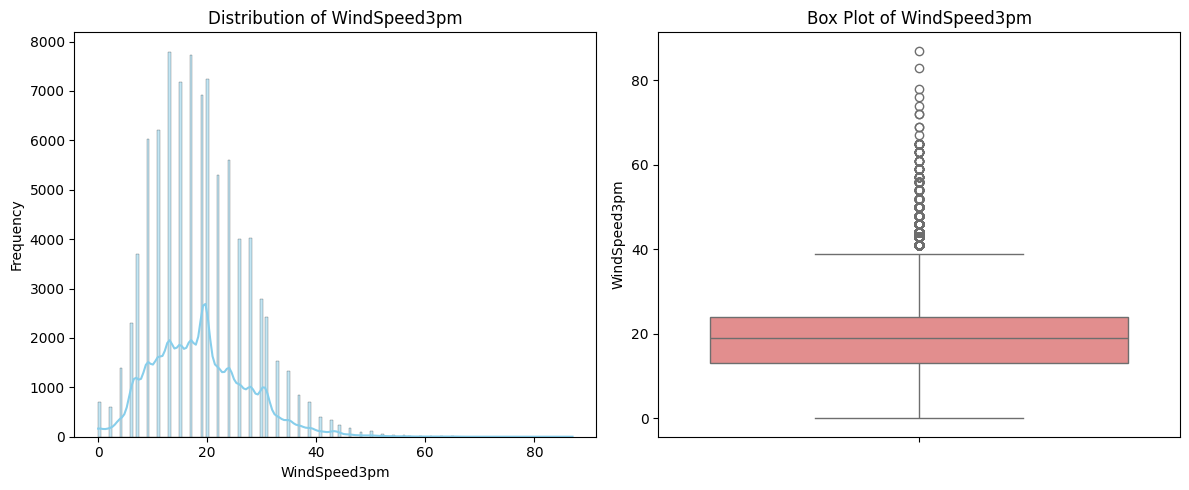

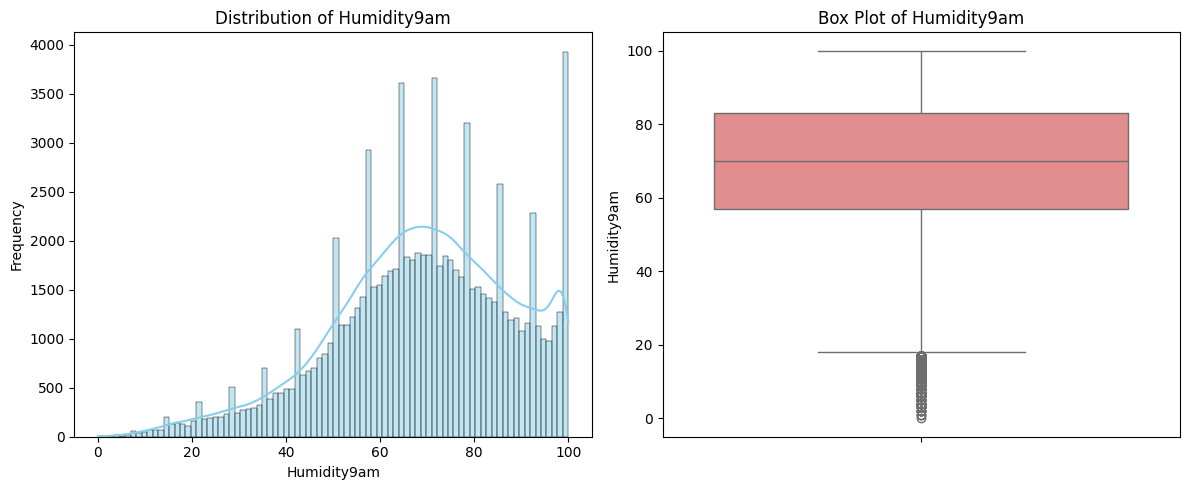

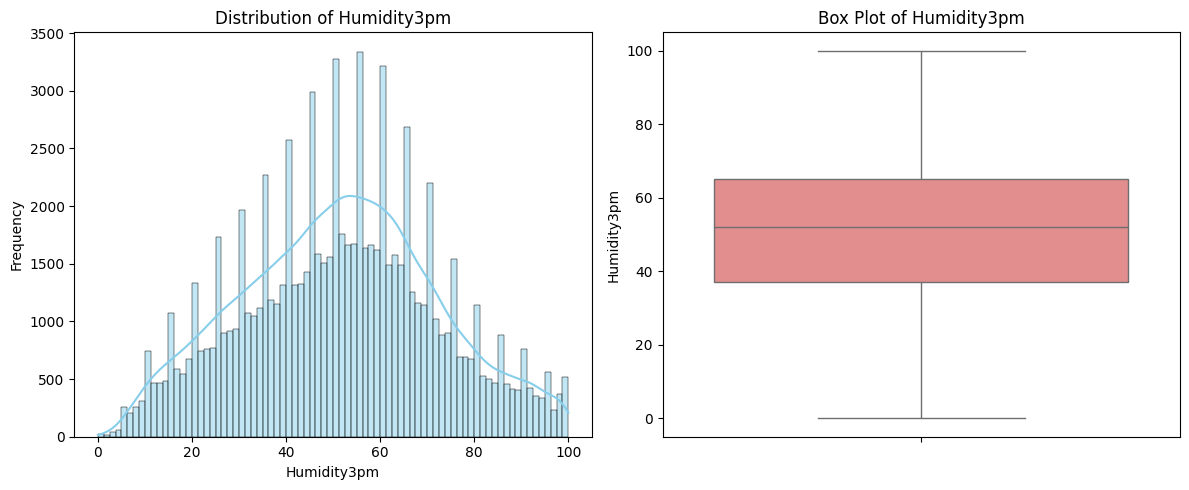

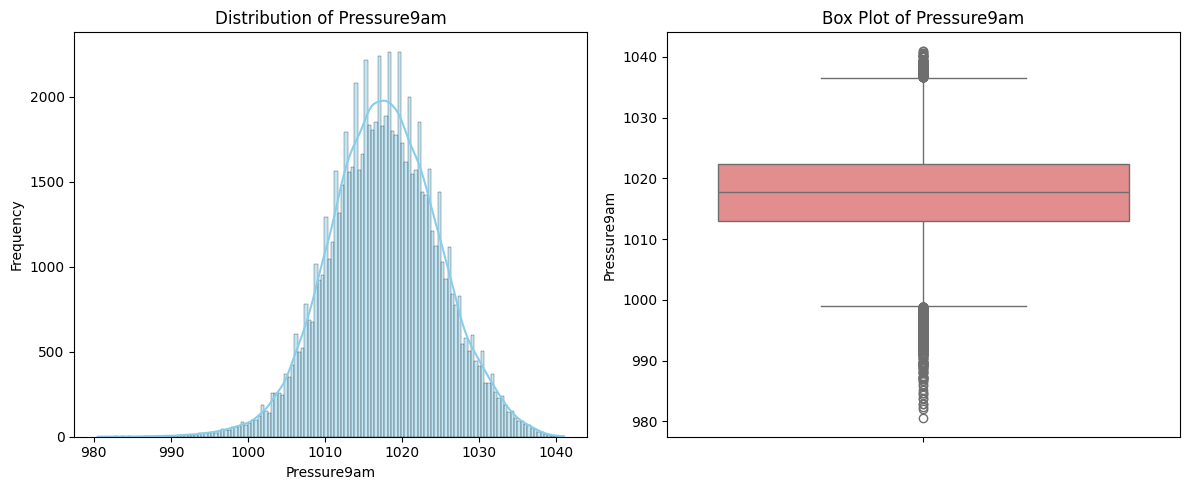

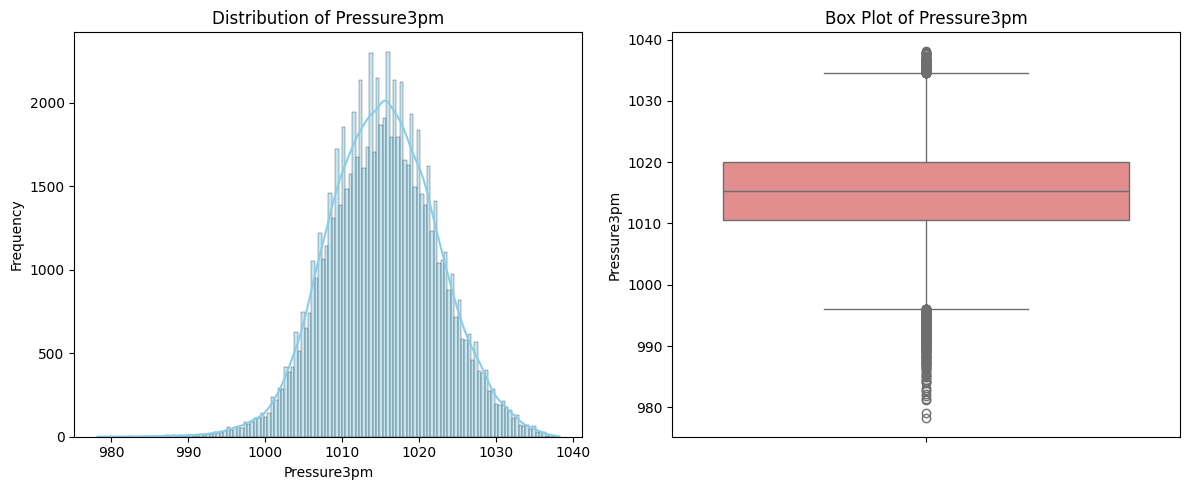

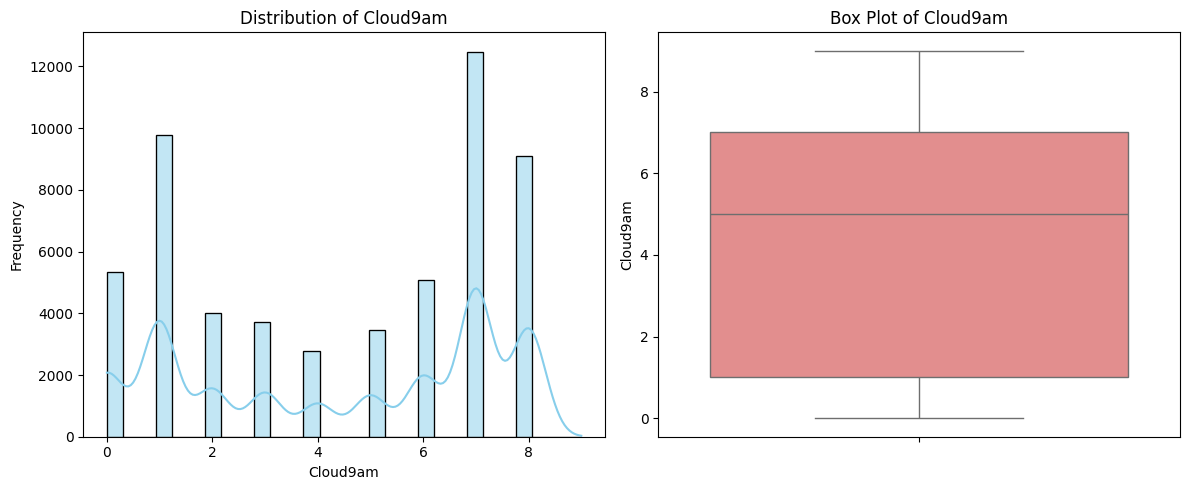

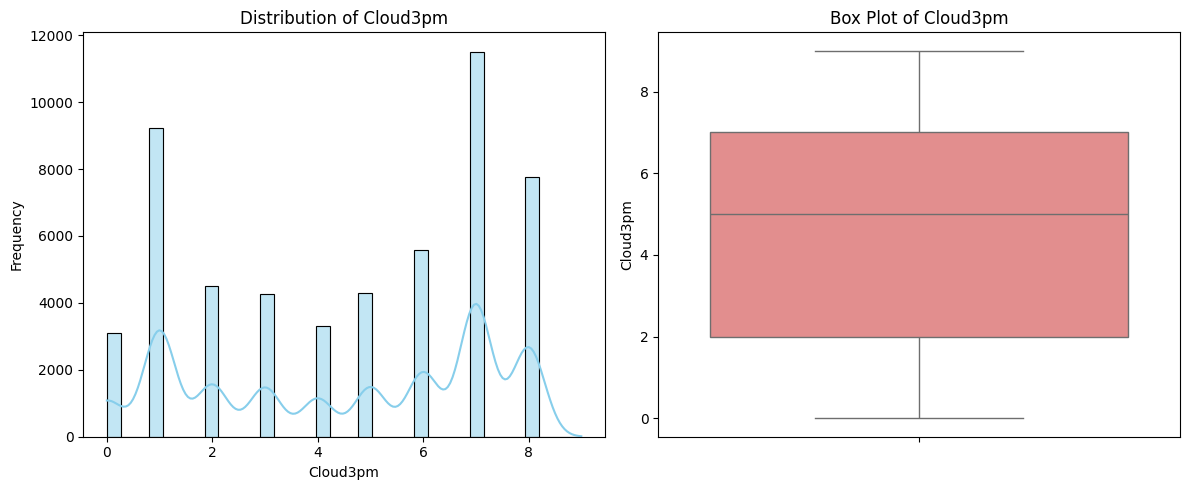

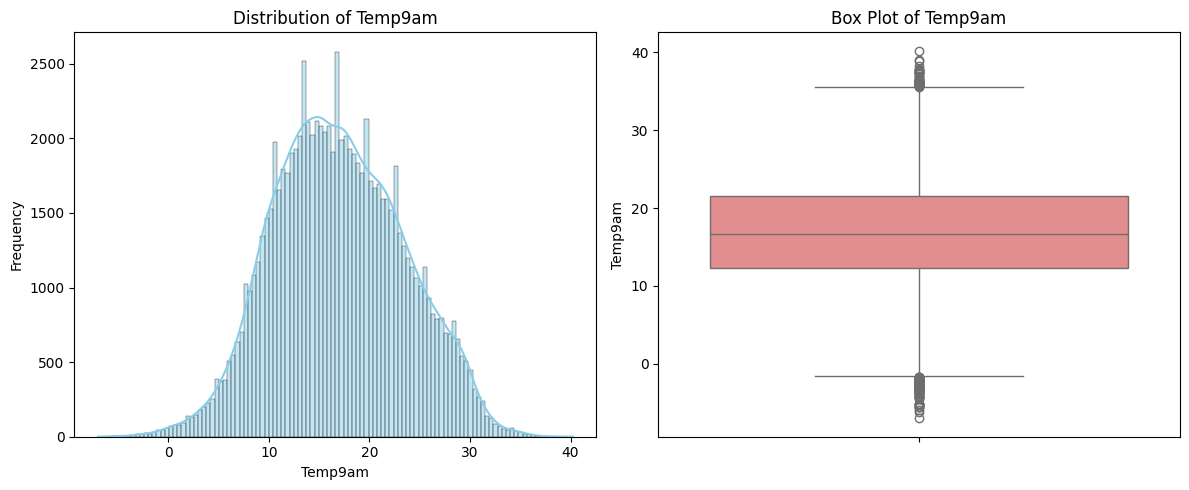

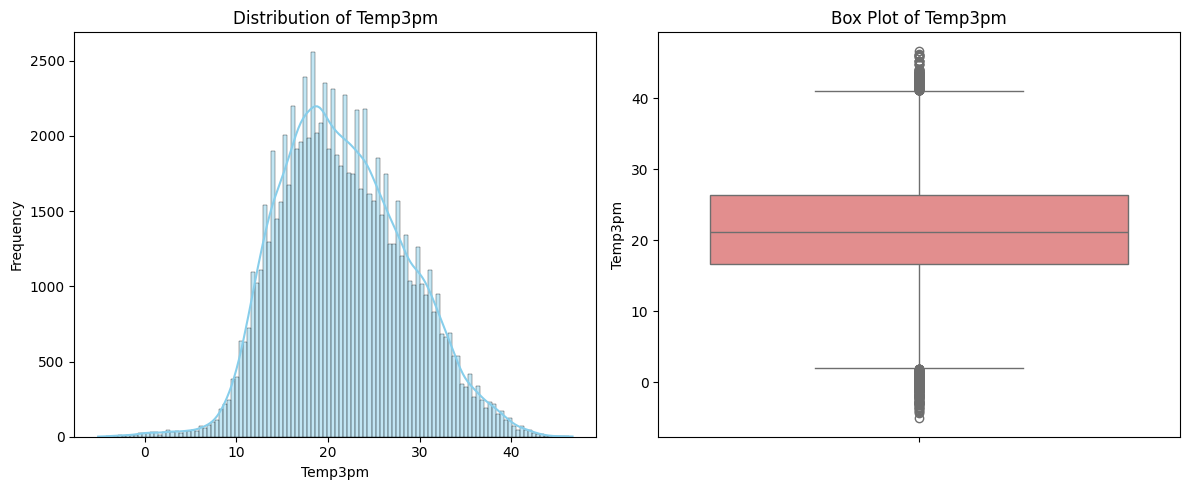

In [82]:
for col in numerical_features.drop(["RainTomorrow"]):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()

**Categorical Features Distribution**

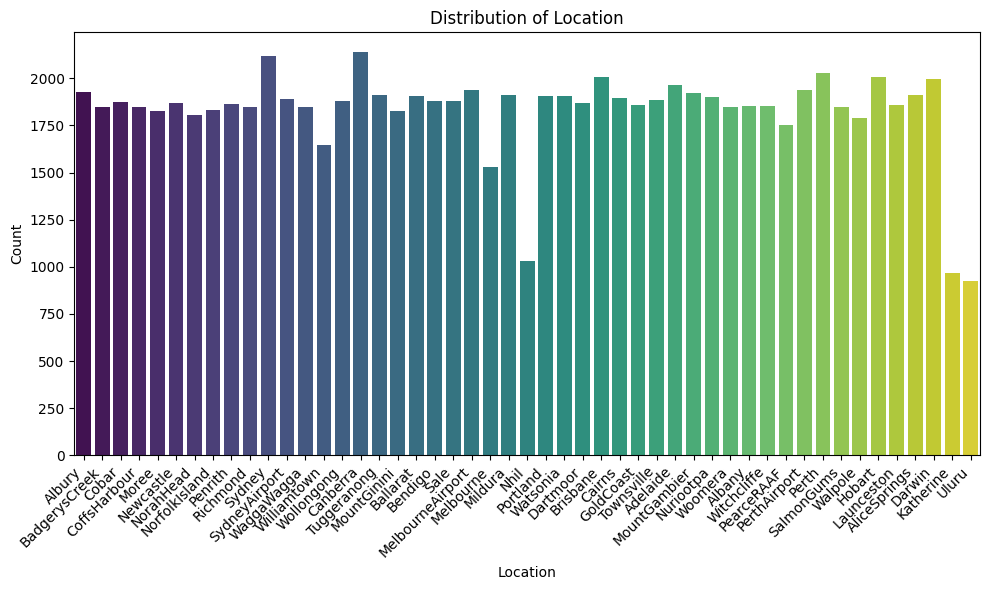

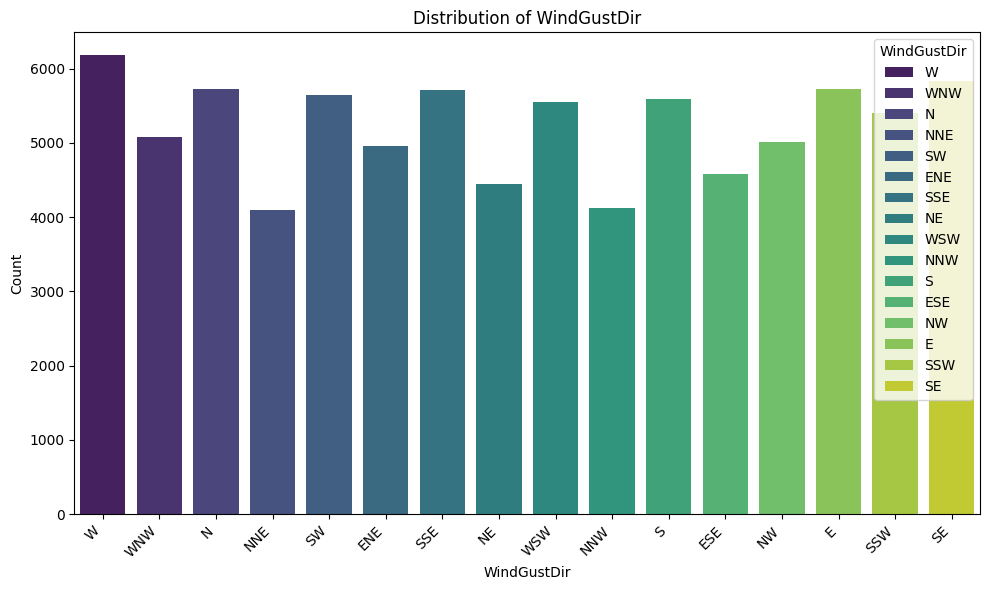

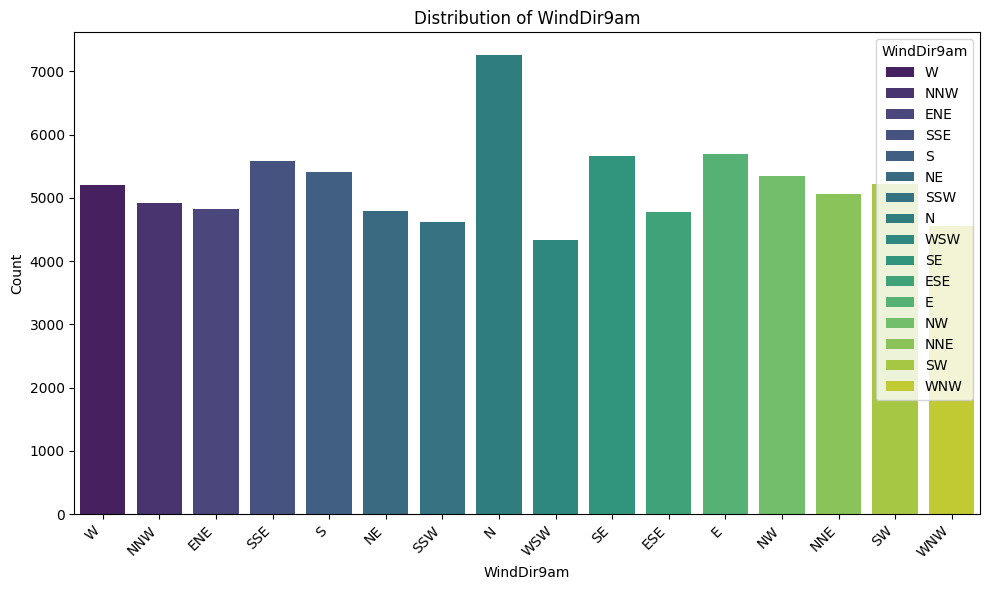

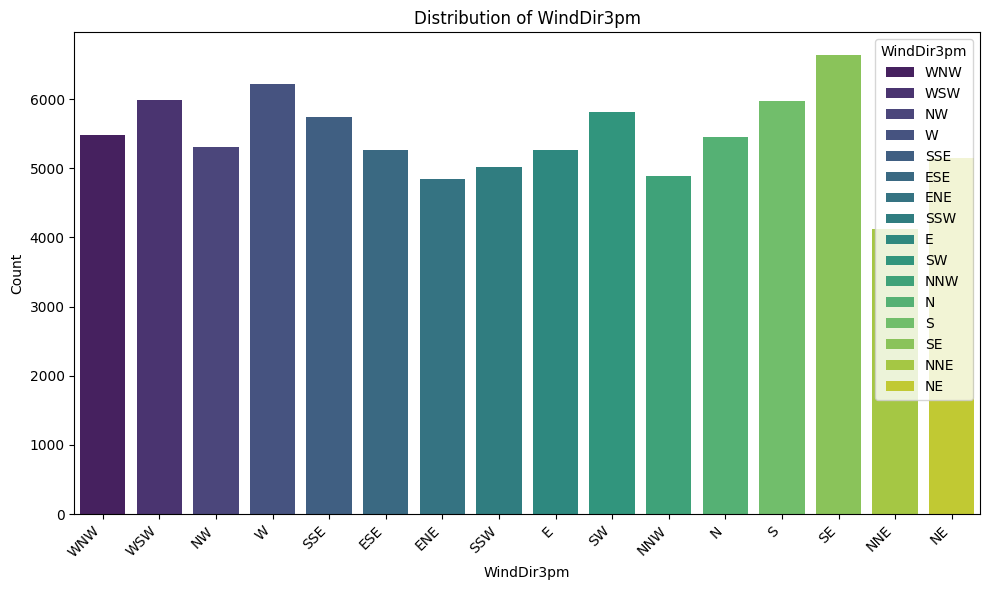

In [83]:
for col in categorical_features.drop(["RainToday"]):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, palette='viridis', hue=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

**Missing Values**

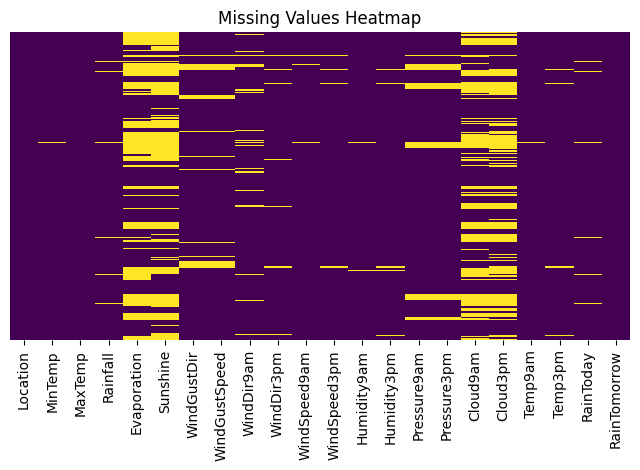

In [84]:
plt.figure(figsize=(8,4))
plt.title("Missing Values Heatmap")
sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.show()

In [85]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)
print("Percentage of Missing Values per Column:\n", missing_percentage)

Percentage of Missing Values per Column:
 Sunshine         47.512393
Evaporation      42.701309
Cloud3pm         40.227100
Cloud9am         37.800902
Pressure9am       9.798580
Pressure3pm       9.786298
WindDir9am        7.043008
WindGustDir       6.547273
WindGustSpeed     6.501496
WindDir3pm        2.659551
Humidity3pm       2.519986
Temp3pm           1.913715
WindSpeed3pm      1.845608
Humidity9am       1.223706
RainToday         0.992586
Rainfall          0.992586
WindSpeed9am      0.936760
Temp9am           0.608503
MinTemp           0.435443
MaxTemp           0.222187
Location          0.000000
RainTomorrow      0.000000
dtype: float64


**Correlation Analysis**

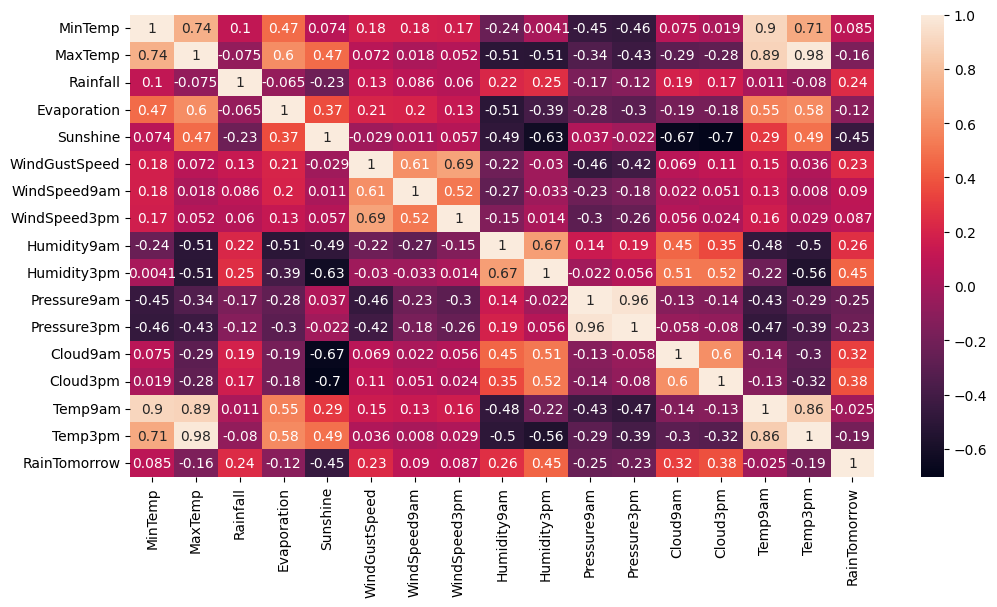

In [86]:
corr = df[numerical_features].corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)
plt.show()

#### Data Preprocessing

**Imputing Categorical Missing Values**

*It's better to impute column according to the location but if we don't have any value for location, i will use entire column*

In [87]:
for col in categorical_features:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df.groupby("Location")[col].transform(lambda s: s.mode()[0] if not s.mode().empty else None))

*Check Mode Imputation*

In [88]:
(df[categorical_features].isnull().sum() / len(df)) * 100

Location       0.000000
WindGustDir    4.155688
WindDir9am     0.000000
WindDir3pm     0.000000
RainToday      0.000000
dtype: float64

*Impute remaining missing values according to the mode of entire feature*

In [89]:
df["WindGustDir"].fillna(df["WindGustDir"].mode()[0], inplace=True)

In [90]:
# Check again
(df[categorical_features].isnull().sum() / len(df)) * 100

Location       0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
dtype: float64

**Imputing Numerical Missing Values**

*I will apply same logic again by imputing accordingly with location*

In [91]:
for col in numerical_features:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df.groupby("Location")[col].transform(lambda s: s.mean() if not s.mean() else None))

*Check Mean Imputation*

In [92]:
(df[numerical_features].isnull().sum() / len(df)) * 100

MinTemp           0.435443
MaxTemp           0.222187
Rainfall          0.992586
Evaporation      42.701309
Sunshine         47.512393
WindGustSpeed     6.501496
WindSpeed9am      0.936760
WindSpeed3pm      1.845608
Humidity9am       1.223706
Humidity3pm       2.519986
Pressure9am       9.798580
Pressure3pm       9.786298
Cloud9am         37.800902
Cloud3pm         40.227100
Temp9am           0.608503
Temp3pm           1.913715
RainTomorrow      0.000000
dtype: float64

*Impute remaining missing values according to the mean of entire feature*

In [93]:
for col in numerical_features:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

In [94]:
# Check again
(df[numerical_features].isnull().sum() / len(df)) * 100

MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustSpeed    0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainTomorrow     0.0
dtype: float64

**Handling Outliers**

In [95]:
numerical_features

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainTomorrow'],
      dtype='object')

In [96]:
def iqr_capping(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)

    return series.clip(lower=lower_bound, upper=upper_bound)

In [97]:
for col in numerical_features.drop("RainTomorrow"):
    df[col] = iqr_capping(df[col])

**One-Hot Encoding**

In [98]:
categorical_features

Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'], dtype='object')

In [99]:
# Convert the 'Yes'/'No' values in the 'RainToday' column to numerical (1/0) representations.
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

In [100]:
df = pd.get_dummies(
    df, 
    columns=categorical_features, 
    drop_first=True,
    dtype=int
)

**Handling Imbalanced Dataset**

In [101]:
majority_class = df[df.RainTomorrow==0]
minority_class = df[df.RainTomorrow==1]

In [102]:
upsampled_class = resample(minority_class, replace=True, n_samples=len(majority_class))

In [103]:
df = pd.concat([majority_class, upsampled_class], axis=0)

**Data Split**

In [104]:
y = df["RainTomorrow"]
X = df.drop(["RainTomorrow"], axis=1)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Scaling**

In [106]:
numerical_features

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainTomorrow'],
      dtype='object')

In [107]:
# Identify binary columns to exclude from scaling
binary_cols = [col for col in numerical_features[:-1] if X_train[col].nunique() == 2 and set(X_train[col].unique()) <= {0, 1}]
binary_cols 

[]

In [108]:
numerical_features_to_scale = [col for col in numerical_features[:-1] if col not in binary_cols]

In [109]:
scaler = StandardScaler()

X_train[numerical_features_to_scale] = scaler.fit_transform(X_train[numerical_features_to_scale])
X_test[numerical_features_to_scale] = scaler.transform(X_test[numerical_features_to_scale])


**PCA**

In [110]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None) # Keep all components for now to inspect variance

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train = pd.DataFrame(X_train_pca, index=X_train.index)
X_test = pd.DataFrame(X_test_pca, index=X_test.index)

print("Explained variance ratio of the principal components:\n", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:\n", pca.explained_variance_ratio_.cumsum())

Explained variance ratio of the principal components:
 [2.51614840e-01 1.68287819e-01 1.04835850e-01 6.10437408e-02
 5.43890184e-02 3.82060507e-02 3.11882226e-02 2.72594124e-02
 2.20144363e-02 2.11191365e-02 1.63489183e-02 1.52629843e-02
 7.73075731e-03 6.63146056e-03 5.60395110e-03 5.15397856e-03
 4.80646475e-03 4.51332606e-03 4.34482816e-03 4.25573018e-03
 4.07556892e-03 3.83710521e-03 3.71521029e-03 3.58427257e-03
 3.57520131e-03 3.48739357e-03 3.37082895e-03 3.34935898e-03
 3.25802753e-03 3.15666808e-03 3.13485084e-03 3.01931533e-03
 3.00908116e-03 2.98452173e-03 2.97075016e-03 2.89178230e-03
 2.83389438e-03 2.76851309e-03 2.73263108e-03 2.71133865e-03
 2.69576150e-03 2.58263405e-03 2.48764560e-03 2.46020898e-03
 2.37464013e-03 2.32550130e-03 2.27552547e-03 2.14321657e-03
 2.07962010e-03 2.01331849e-03 1.92951929e-03 1.87516772e-03
 1.72921271e-03 1.69624391e-03 1.50856162e-03 1.36104927e-03
 1.29071940e-03 1.24621756e-03 1.20062529e-03 1.19152356e-03
 1.17393340e-03 1.16337958e-03

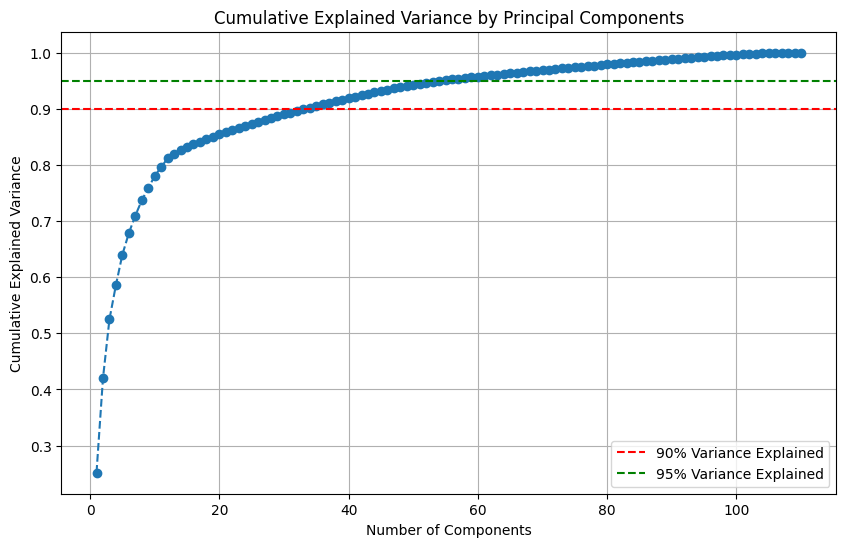

Number of components to explain 90% variance: 34
Number of components to explain 95% variance: 55


In [111]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance Explained')
plt.grid(True)
plt.legend()
plt.show()

num_components_90 = next(i for i, cumulative_variance in enumerate(pca.explained_variance_ratio_.cumsum()) if cumulative_variance >= 0.90) + 1
num_components_95 = next(i for i, cumulative_variance in enumerate(pca.explained_variance_ratio_.cumsum()) if cumulative_variance >= 0.95) + 1

print(f"Number of components to explain 90% variance: {num_components_90}")
print(f"Number of components to explain 95% variance: {num_components_95}")

In [112]:
X_train = pd.DataFrame(X_train_pca[:, :34], index=X_train.index)
X_test = pd.DataFrame(X_test_pca[:, :34], index=X_test.index)

print(f"New shape of X_train: {X_train.shape}")
print(f"New shape of X_test: {X_test.shape}")

New shape of X_train: (111112, 34)
New shape of X_test: (27778, 34)


#### Train and Evaluate

In [113]:
# A dictionary to store the results for comparison
results = {}

In [114]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = y_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Rain'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    return model

In [115]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

**Logistic Regression**

In [116]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

In [117]:
lr_grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=10000),
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

In [118]:
lr_grid.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.5s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.3s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.3s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.4s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.4s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.9s
[CV] END ...........................C=0.01, solver=liblinear; total time=   1.0s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.4s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.4s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.0s
[CV] END ...........................C=0.01, solver=liblinear; total time=   1.1s
[CV] END ..................................C=1, 

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.001, 0.01, ...], 'solver': ['liblinear', 'lbfgs']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'



--- Logistic Regression Evaluation ---
Accuracy: 0.7767
Precision: 0.7774
Recall: 0.7708
F1-Score: 0.7741
ROC AUC: 0.8617


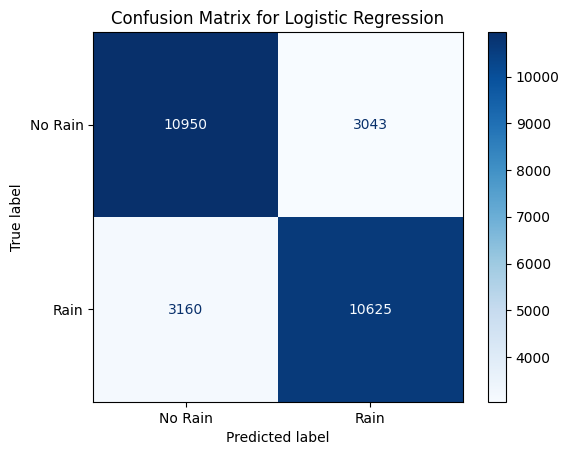

Best LR Parameters: {'C': 1, 'solver': 'liblinear'}


In [119]:
best_lr = evaluate_model(lr_grid.best_estimator_, X_test, y_test, "Logistic Regression")
print(f"Best LR Parameters: {lr_grid.best_params_}")

**K-Nearest Neighbors (KNN)**

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END algorithm=auto, n_neighbors=5, p=2, weights=uniform; total time=  16.5s
[CV] END algorithm=auto, n_neighbors=5, p=2, weights=distance; total time=  16.5s
[CV] END algorithm=auto, n_neighbors=5, p=2, weights=uniform; total time=  17.6s
[CV] END algorithm=auto, n_neighbors=5, p=2, weights=distance; total time=  17.6s
[CV] END algorithm=auto, n_neighbors=5, p=1, weights=uniform; total time= 1.9min
[CV] END algorithm=auto, n_neighbors=5, p=1, weights=distance; total time= 1.9min
[CV] END algorithm=auto, n_neighbors=5, p=1, weights=uniform; total time= 1.9min
[CV] END algorithm=auto, n_neighbors=5, p=1, weights=distance; total time= 1.9min
[CV] END algorithm=auto, n_neighbors=7, p=1, weights=uniform; total time= 1.8min
[CV] END algorithm=auto, n_neighbors=7, p=1, weights=distance; total time= 1.8min
[CV] END algorithm=auto, n_neighbors=7, p=1, weights=uniform; total time= 1.8min
[CV] END algorithm=auto, n_neighbors=7, p=2

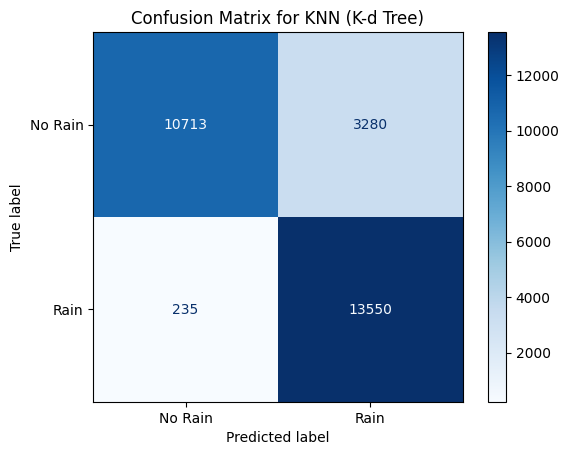

Best KNN Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


In [120]:
param_grid_knn = {
    'n_neighbors': [5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'kd_tree']
}

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

best_knn = evaluate_model(knn_grid.best_estimator_, X_test, y_test, "KNN (K-d Tree)")
print(f"Best KNN Parameters: {knn_grid.best_params_}")

**Simple Support Vector Machine (SVM)**

In [121]:
svm_model = SimpleSVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)

In [122]:
svm_model.fit(X_train, y_train)


--- Support Vector Machine Evaluation ---
Accuracy: 0.7743
Precision: 0.7797
Recall: 0.7598
F1-Score: 0.7696
ROC AUC: 0.7742


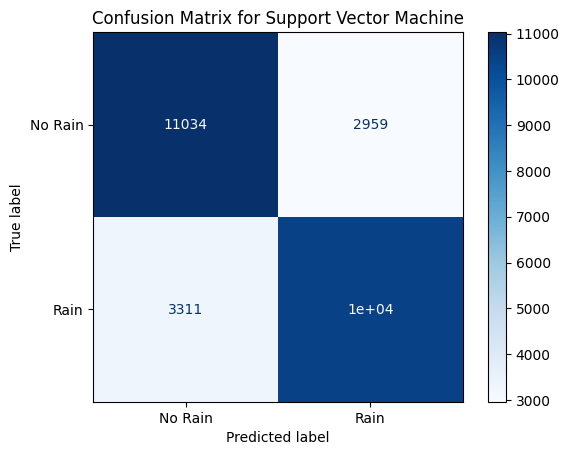

In [123]:
best_svm = evaluate_model(svm_model, X_test, y_test, "Support Vector Machine")

**Decision Tree**

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ..ccp_alpha=0.001, max_depth=15, min_samples_leaf=5; total time=   5.7s
[CV] END ..ccp_alpha=0.001, max_depth=15, min_samples_leaf=5; total time=   5.6s
[CV] END ..ccp_alpha=0.01, max_depth=20, min_samples_leaf=10; total time=   5.7s
[CV] END .ccp_alpha=0.001, max_depth=20, min_samples_leaf=10; total time=   5.6s
[CV] END ..ccp_alpha=0.01, max_depth=20, min_samples_leaf=10; total time=   5.8s
[CV] END .ccp_alpha=0.001, max_depth=20, min_samples_leaf=10; total time=   6.0s
[CV] END ..ccp_alpha=0.001, max_depth=20, min_samples_leaf=5; total time=   6.1s
[CV] END ..ccp_alpha=0.001, max_depth=20, min_samples_leaf=5; total time=   6.2s
[CV] END ...ccp_alpha=0.01, max_depth=20, min_samples_leaf=5; total time=   3.3s
[CV] END ...ccp_alpha=0.01, max_depth=20, min_samples_leaf=5; total time=   3.0s

--- Decision Tree (Pruned) Evaluation ---
Accuracy: 0.7484
Precision: 0.7339
Recall: 0.7735
F1-Score: 0.7532
ROC AUC: 0.8164


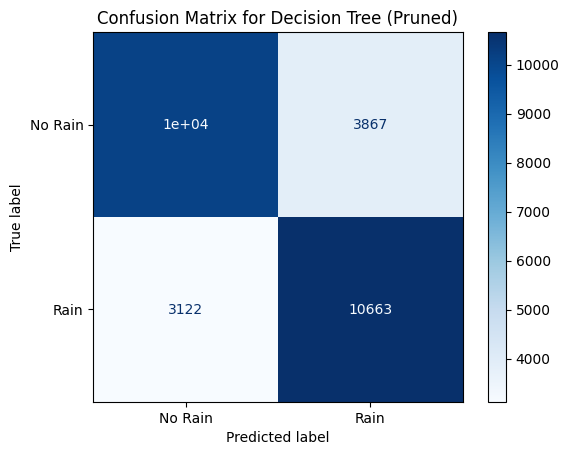

Best DT Parameters: {'min_samples_leaf': 5, 'max_depth': 15, 'ccp_alpha': 0.001}


In [124]:
param_dist_dt = {
    'max_depth': [15, 20],
    'min_samples_leaf': [5, 10],
    'ccp_alpha': [0.001, 0.01]
}

dt_grid = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    scoring='accuracy',
    cv=skf,
    n_iter=5,
    verbose=2,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

best_dt = evaluate_model(dt_grid.best_estimator_, X_test, y_test, "Decision Tree (Pruned)")
print(f"Best DT Parameters: {dt_grid.best_params_}")

**Random Forest**

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=  55.9s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=  56.0s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=400; total time= 1.8min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=  54.0s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=400; total time= 1.8min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=  54.5s
[CV] END .max_depth=20, min_samples_leaf=5, n_estimators=400; total time= 2.2min
[CV] END .max_depth=20, min_samples_leaf=5, n_estimators=400; total time= 2.2min
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=400; total time= 2.3min
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=400; total time= 2.3min

--- Random Forest Evaluation ---
Accuracy: 0.9325
Precision: 0.8994
Recall: 0.9729
F1-Score: 0.9347
ROC AUC: 0.9870


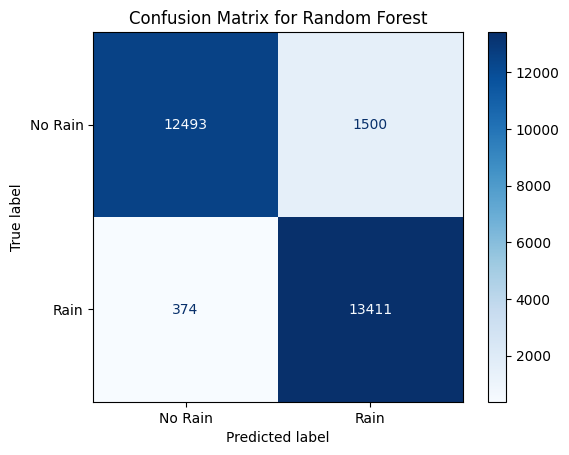

Best Random Forest Parameters: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_depth': 20}


In [125]:
param_dist_rf = {
    'n_estimators': [200, 400],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 5],
}


rf_rand = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=5,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_rand.fit(X_train, y_train)

best_rf = evaluate_model(rf_rand.best_estimator_, X_test, y_test, "Random Forest")
print(f"Best Random Forest Parameters: {rf_rand.best_params_}")

**AdaBoost**

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  46.6s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=  47.1s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=  47.4s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=  47.4s
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 1.2min
[CV] END ................learning_rate=0.1, n_estimators=200; total time= 1.3min
[CV] END ................learning_rate=0.5, n_estimators=200; total time= 1.2min
[CV] END ................learning_rate=0.5, n_estimators=200; total time= 1.2min

--- AdaBoost Evaluation ---
Accuracy: 0.7724
Precision: 0.7650
Recall: 0.7813
F1-Score: 0.7731
ROC AUC: 0.8580


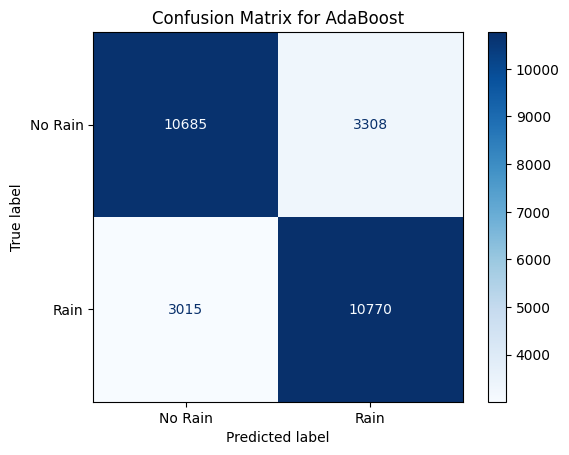

Best AdaBoost Parameters: {'n_estimators': 200, 'learning_rate': 0.5}


In [126]:
param_dist_ada = {
    'n_estimators': [100, 200],    
    'learning_rate': [ 0.1, 0.5] 
}

ada_rand = RandomizedSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_distributions=param_dist_ada,
    n_iter=4,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

ada_rand.fit(X_train, y_train)

best_ada = evaluate_model(ada_rand.best_estimator_, X_test, y_test, "AdaBoost")
print(f"Best AdaBoost Parameters: {ada_rand.best_params_}")

**Gradient Boosting**

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.2min
[CV] END learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.3min
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.3min
[CV] END learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.3min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time= 2.2min
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time= 2.2min
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time= 4.4min
[CV] END learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time= 4.4min

--- Gradi

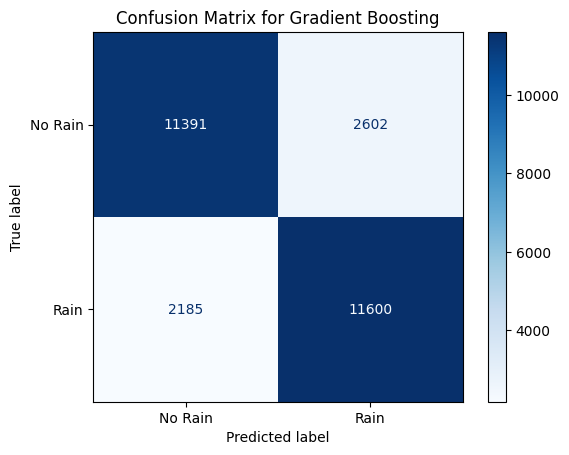

Best Gradient Boosting Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}


In [127]:
param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8]
}

gb_rand = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb,
    n_iter=5,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

gb_rand.fit(X_train, y_train)

best_gb = evaluate_model(gb_rand.best_estimator_, X_test, y_test, "Gradient Boosting")
print(f"Best Gradient Boosting Parameters: {gb_rand.best_params_}")

**XGBoost**

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   1.1s
[CV] END colsample

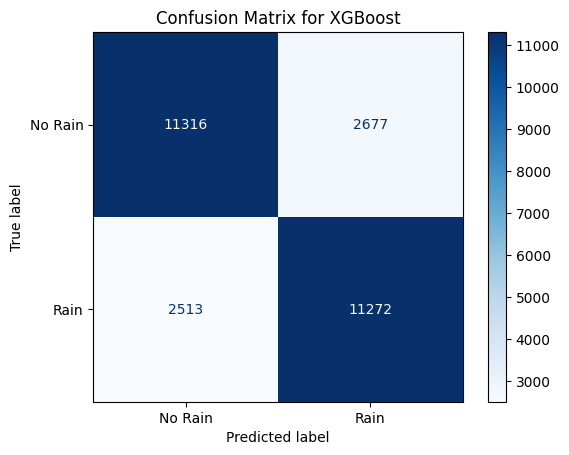

Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [128]:
param_dist_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'colsample_bytree': [0.7, 1.0],
    'subsample': [0.7, 1.0]
}


xgb_rand = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
    param_distributions=param_dist_xgb,
    n_iter=5,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_rand.fit(X_train, y_train)

best_xgb = evaluate_model(xgb_rand.best_estimator_, X_test, y_test, "XGBoost")
print(f"Best XGBoost Parameters: {xgb_rand.best_params_}")

**Voting**

In [162]:
estimators = [
    ('LogisticRegression', best_lr),
    ('KNeighbors', best_knn),
    ('DecisionTree', best_dt),
    ('RandomForest', best_rf),
    ('AdaBoost', best_ada),
    ('GradientBoosting', best_gb),
    ('XGBoost', best_xgb)
]

In [163]:
voting_clf = VotingClassifier(
    estimators=estimators, 
    voting='soft',
)

In [164]:
voting_clf.fit(X_train, y_train)

,estimators,"[('LogisticRegression', ...), ('KNeighbors', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True



--- Voting Evaluation ---
Accuracy: 0.8674
Precision: 0.8331
Recall: 0.9163
F1-Score: 0.8727
ROC AUC: 0.9436


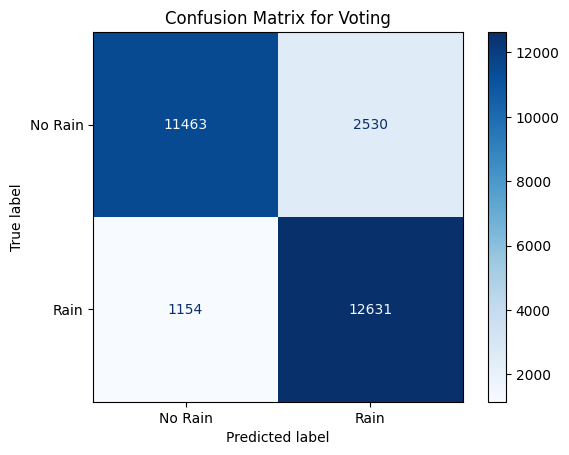

In [165]:
voting = evaluate_model(voting_clf, X_test, y_test, "Voting")

**Model Comparison and Summary**


--- Model Performance Comparison (Sorted by ROC-AUC) ---
                        Accuracy  Precision    Recall  F1-Score   ROC-AUC
Random Forest           0.932537   0.899403  0.972869  0.934695  0.986999
KNN (K-d Tree)          0.873461   0.805110  0.982952  0.885187  0.969981
Voting                  0.867377   0.833124  0.916286  0.872729  0.943642
Gradient Boosting       0.827669   0.816786  0.841494  0.828956  0.909493
XGBoost                 0.813161   0.808087  0.817700  0.812865  0.897369
Logistic Regression     0.776694   0.777363  0.770765  0.774050  0.861662
AdaBoost                0.772374   0.765023  0.781284  0.773068  0.858001
Decision Tree (Pruned)  0.748398   0.733861  0.773522  0.753170  0.816367
Support Vector Machine  0.774282   0.779722  0.759811  0.769638  0.774174


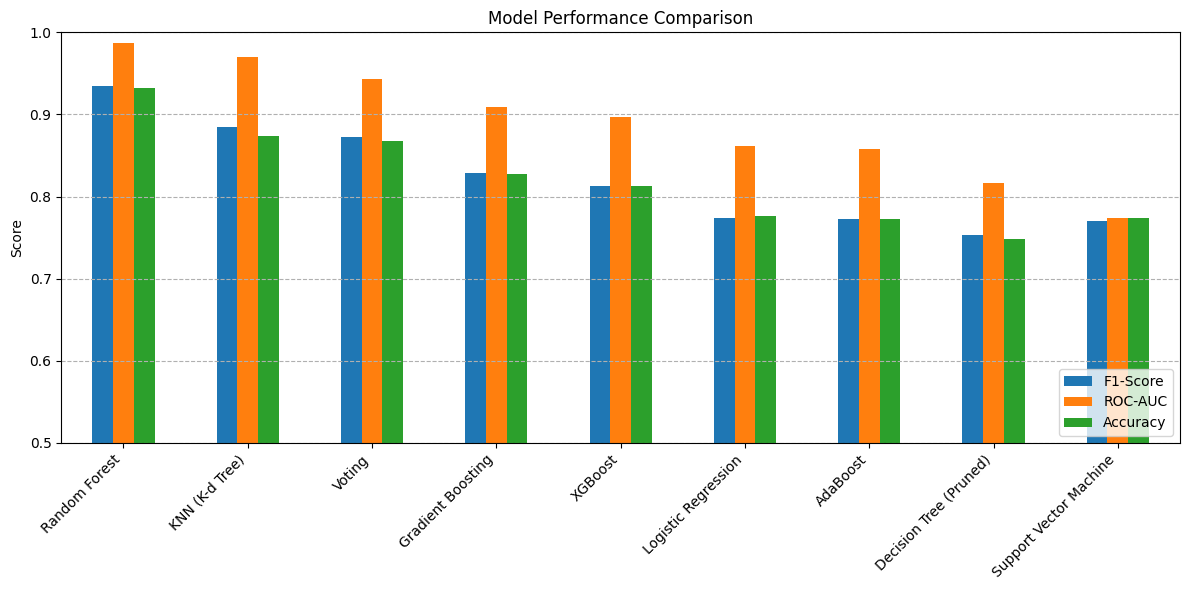

In [166]:
results_df = pd.DataFrame(results).T.sort_values(by='ROC-AUC', ascending=False)

print("\n--- Model Performance Comparison (Sorted by ROC-AUC) ---")
print(results_df)

metrics_to_plot = ['F1-Score', 'ROC-AUC', 'Accuracy']
results_df[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

**Save Best Model**

In [172]:
filename = 'random_forest_rain_prediction_model.pkl'

In [173]:
joblib.dump(best_rf, filename)

['random_forest_rain_prediction_model.pkl']